## **EKG-Anomalieerkennung mithilfe des LSTM Autoencoders**


### **Vorwort**

Dieses Projekt befasst sich mit der Entwicklung eines unüberwachten Modells, das mithilfe eines LSTM-Autoencoders in der Lage ist, normale und abnormale EKG-Signale von einander zu unterscheiden.

Die Arbeit ist in fünf Teile gegliedert. Im ersten Teil erfolgt eine kurze theoretische Fundierung zu den Themen Autoencoder und LSTM. Der zweite Teil beschäftigt sich mit der Datenaufbereitung, gefolgt von einer kurzen explorativen Analyse im dritten Teil. Abschließend, welches auch den Kern dieser Arbeit wiederspiegelt, befasst sich mit der Modellentwicklung und dessen Evaluierung und Beurteilung.

Bevor wir aber mit der Arbeit beginnen, werden wir hier zunächst die benötigten Python-Bibliotheken importieren.

In [227]:
# Data Science Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Deep Learning Module
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

# Bilder importieren
from IPython.display import HTML

# Mögliche Warnings ignorieren
import warnings
warnings.filterwarnings("ignore")

### **1. Theoretische Fundierung**

### **1.1. RNNs und LSTM**

Rekurrente Neuronale Netze oder kurz RNNs, sind Neuronale Netze, die für die Verarbeitung von **sequentiellen Daten** wie Texten, Zeitreihen oder auch Sprachen verwendet werden können. 

Hier nochmal ein einfaches neuronales Netzwerk mit einer Eingabeschicht, einer versteckten Schicht und einer Ausgabeschicht: 

<img src="./images/NN.png" width="250">

Im Gegensatz zu solchen "gewöhnlichen" neuronalen Netzen, die nur einzelne Eingaben verarbeiten, können RNNs die vorherigen Ausgaben als zusätzliche Eingaben nutzen, um Entscheidungen auf Basis der gesamten Sequenz zu treffen. Ein RNN besteht aus einer Schleife, die es ihm ermöglicht, seine internen Zustände zu aktualisieren und Informationen aus der Vergangenheit zu behalten [7].

<img src="./images/RNN.png" width="150">

 Diese Schleife erlaubt es dem Netzwerk, seine Ausgabe für einen bestimmten Zeitschritt nicht nur von der aktuellen Eingabe, sondern auch von seinem internen Zustand abhängig zu machen, der aufgrund der vorherigen Eingaben berechnet wurde. Dies bedeutet, dass das Netzwerk in der Lage ist, auf die Abfolge der Inputs zu reagieren und den Kontext der Eingabe zu verstehen. RNNs haben somit die Fähigkeit, sich an frühere Informationen zu erinnern!

Es gibt jedoch ein Problem des verschwindenden oder explodierenden Gradienten, auf welches wir hier nicht weiter eingehen werden, doch dies führt zu, dass das RNN nicht in der Lage ist, komplexe Sequenzen zu erlernen und falsche Ergebnisse liefert. 

**Um dieses Problem zu beheben verwenden wir das sogenannte LSTM-Modell (Long Short-Term Memory).**

<img src="./images/LSTM.png" width="450">

### **1.2. Autoencoder**

Ein Autoencoder ist ein Algorithmus aus dem unüberwachtem Lernen, der zur Dimensionalitätsreduktion oder zum Entfernen von Rauschen in Daten verwendet wird. Es besteht aus zwei Teilen: dem Encoder und dem Decoder. Der Encoder reduziert die Eingabe in einen niedrigerdimensionalen Vektor, und der Decoder rekonstruiert die ursprüngliche Eingabe aus diesem Vektor. Während des Trainings wird das Netzwerk so eingestellt, dass die Differenz zwischen der Eingabe und der rekonstruierten Ausgabe minimiert wird.

Autoencoder werden oft zur Anomalieerkennung eingesetzt, da sie in der Lage sind, die normalen Muster in den Daten zu erfassen und Abweichungen von diesen Mustern zu erkennen. Wenn ein ungewöhnlicher Datenpunkt in das Netzwerk eingespeist wird, kann der Decoder den Punkt nicht so genau rekonstruieren, was auf eine Anomalie hinweist.


<img src="./images/autoencoder.png" width="350">

LSTMs und Autoencoder eignen sich somit hervorragend für die Anomalieerkennung, da sie beide auf sequentiellen Daten arbeiten können. LSTMs sind in der Lage, langfristige Abhängigkeiten in Zeitreihen zu modellieren, während Autoencoder in der Lage sind, Muster und Merkmale aus den Daten zu extrahieren. Durch die Kombination von Autoencoder und LSTM können somit anomale Muster in den Daten auf einer höheren Abstraktionsebene erkannt werden, was zu einer höheren Erkennungsgenauigkeit führt.

In einem solchen **hybriden Modell** werden die Eingabedaten von einem Autoencoder komprimiert und in einen niedrigerdimensionalen Vektor transformiert. Der LSTM verwendet diesen Vektor als Eingabe, um den nächsten Zustand in der Sequenz vorherzusagen. Wenn der LSTM einen ungewöhnlichen Zustand in der Eingabesequenz erkennt, kann dies darauf hinweisen, dass eine Anomalie vorliegt. Der Autoencoder kann dann verwendet werden, um die anomale Stelle in den Daten zu lokalisieren und den Grad der Abweichung von den normalen Mustern zu quantifizieren.

### **2. Datenaufbereitung**

Der folgende Datensatz enthält die EKG-Aufzeichnungen von Patienten [1]. Dabei entspricht jede Zeile bzw. Beobachtung einem vollständigen EKG eines Patienten. Jedes einzelne EKG umfasst dabei 140 Messwerte. Die Spalten 0 bis 139 enthalten die EKG-Datenpunkte für einen bestimmten Patienten. Die letzte Spalte ist eine kategorische Variable mit dem Wert 0 oder 1 und ist ein binärer Indikator dafür, ob das EKG als ein normales oder abnormales Signal ist.

In [228]:
df = pd.read_csv('data/ecg.csv', header = None)
df.rename(columns={df.columns[140]: 'Beschriftung'}, inplace=True)
new_column_names = {i: f"Messung {i+1}" for i in range(140)}
df = df.rename(columns=new_column_names)
df.head()

,Messung 1,Messung 2,Messung 3,Messung 4,Messung 5,Messung 6,Messung 7,Messung 8,Messung 9,Messung 10,...,Messung 132,Messung 133,Messung 134,Messung 135,Messung 136,Messung 137,Messung 138,Messung 139,Messung 140,Beschriftung
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Die CSV-Datei beinhaltet 4998 Zeilen und 141 Spalten, welches man mit Hilfe des Shape Befehls entnehmen kann.

In [229]:
print(df.shape)

(4998, 141)


In [230]:
# Gruppiere die Daten nach der Beschriftungsspalte
groups = df.groupby('Beschriftung')
# Teile die Daten in normale und anomale Datensätze auf
normal_data = groups.get_group(1)
anomalous_data = groups.get_group(0)

In [231]:
normal_data = df[df['Beschriftung'] == 1].drop('Beschriftung', axis=1)
normal_data.head()

,Messung 1,Messung 2,Messung 3,Messung 4,Messung 5,Messung 6,Messung 7,Messung 8,Messung 9,Messung 10,...,Messung 131,Messung 132,Messung 133,Messung 134,Messung 135,Messung 136,Messung 137,Messung 138,Messung 139,Messung 140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [232]:
normal_data.shape

(2919, 140)

In [233]:
anomalous_data = df[df['Beschriftung'] == 0].drop('Beschriftung', axis=1)
anomalous_data.head()

,Messung 1,Messung 2,Messung 3,Messung 4,Messung 5,Messung 6,Messung 7,Messung 8,Messung 9,Messung 10,...,Messung 131,Messung 132,Messung 133,Messung 134,Messung 135,Messung 136,Messung 137,Messung 138,Messung 139,Messung 140
292,-0.032245,-0.545050,-0.822340,-1.605085,-1.805775,-2.008067,-2.233975,-2.191458,-2.058071,-1.880849,...,-0.906425,-1.621376,-2.329090,-3.049894,-3.620413,-4.210482,-4.043785,-3.051813,-2.806866,-0.879666
293,-0.003377,-0.279265,-0.230519,-0.635978,-0.894795,-1.023105,-1.243738,-1.458372,-1.677896,-1.784530,...,-2.155969,-2.640508,-3.218384,-3.651630,-3.881198,-3.924672,-3.164390,-2.228373,-1.837544,-0.378489
294,0.195989,-0.222258,-0.754773,-1.415614,-1.775851,-2.162326,-2.467492,-2.331384,-1.993476,-1.611709,...,-0.162438,-0.935030,-1.654340,-2.434240,-3.472170,-4.280780,-4.629438,-3.794192,-2.851468,-1.743521
295,0.894867,-0.003822,-0.751052,-1.396543,-1.737838,-2.113020,-2.213210,-2.203347,-2.024191,-1.591458,...,-0.899746,-1.441516,-1.861612,-2.321381,-2.884877,-3.530246,-4.412515,-3.903331,-3.567106,-1.536338
296,1.250060,0.760800,0.042925,-0.627974,-0.963454,-1.261335,-1.652440,-1.888433,-1.935217,-1.808429,...,-0.695282,-0.979223,-1.353969,-1.952051,-2.640386,-3.000281,-3.812490,-3.973360,-5.221946,-3.661793


In [234]:
anomalous_data.shape

(2079, 140)

### **3. Explorative Datenanalyse**

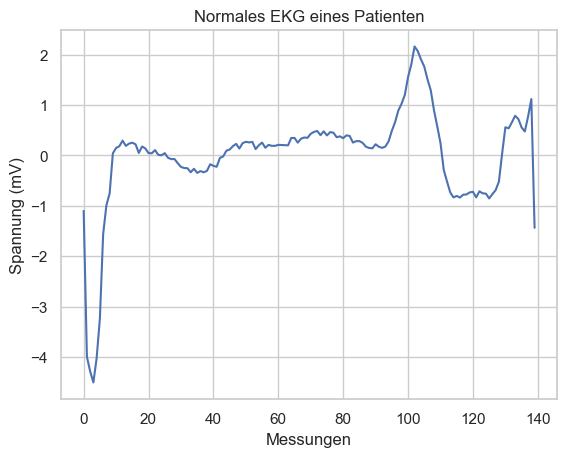

In [235]:
ekg_daten_normal = normal_data.iloc[1,:].values
plt.plot(ekg_daten_normal)
plt.title("Normales EKG eines Patienten")
plt.xlabel("Messungen")
plt.ylabel("Spannung (mV)")
plt.show()

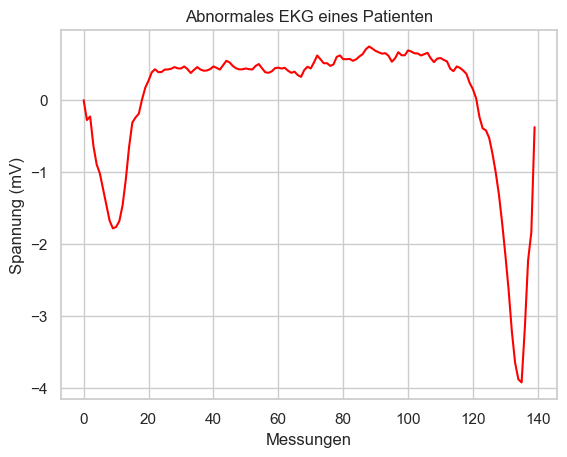

In [236]:
ekg_daten_abnormal = anomalous_data.iloc[1,:].values
plt.plot(ekg_daten_abnormal, color = 'red')
plt.title("Abnormales EKG eines Patienten")
plt.xlabel("Messungen")
plt.ylabel("Spannung (mV)")
plt.show()

### **4. Modellentwicklung und Evaluierung**

*Für diesen Abschnitt fließen folgende Quellen und Hintergrundwissen ein. Zumal ist es die Arbeit als Data Scientist und die erste praktische Erfarung die man bzgl. Zeitreihen und LSTM-Modellen sammeln konnte. Ebenso die Kurse Deep Learning und NLP der FH SWF von Herr Prof. Gawron und die Quellen [4], [6] und [7] welche sich als sehr hilfreich erwiesen haben.*

**Der untere Code kann in 5 Schritten aufgeteilt werden:**

**Schritt 1 - Skalierung der Daten:** 

Zunächst werden die Daten, die in der Variable "normal_data" und "anomalous_data" gespeichert sind, skaliert, um sicherzustellen, dass alle Datenpunkte im gleichen Bereich liegen. Dazu wird die Funktion "MinMaxScaler" aus dem Modul "sklearn.preprocessing" verwendet, die die Daten auf den Bereich zwischen 0 und 1 skaliert. Das Ergebnis der Skalierung wird in den Variablen "scaled_normal_data" und "scaled_anomalous_data" gespeichert.

**Schritt 2 - Konvertierung in 3D-Tensor-Form:** 

Die normalen und anomalen Daten werden dann in die Form eines 3D-Tensors konvertiert, um sie für das Modell geeignet zu machen. Der 3D-Tensor hat die Form (Anzahl der Beobachtungen, Zeitschritte, Anzahl der Merkmale). Dazu wird die Funktion "np.reshape" verwendet, die die Daten in die gewünschte Form bringt. Das Ergebnis wird in den Variablen "normal_data_3d" und "anomalous_data_3d" gespeichert.

**Schritt 3 - Konvertierung in 3D-Tensor-Form:** 

Aufteilung in Trainings- und Testdaten: Die normalen Daten werden in Trainings- und Testdaten aufgeteilt. Hierfür wird zuerst die Größe des Trainingsdatensatzes auf 80% der normalen Daten festgelegt. Der Trainingsdatensatz besteht aus den ersten 80% der normalen Daten, während der Testdatensatz aus den verbleibenden 20% der normalen Daten und allen anomalen Daten besteht. **Dies ist ein sehr entscheidender Punkt!**

Die Trainingsdaten werden in der Variablen "train_data" gespeichert, während die Testdaten in der Variablen "test_data" gespeichert werden.

**Schritt 4 - Definition des LSTM-Autoencoder-Modells:** 

Das Modell wird definiert, indem zunächst die Eingabeformate definiert werden, die der Form des 3D-Tensors entsprechen. Dann wird ein LSTM-Encoder-Layer definiert, der die Eingabe kodiert und einen latenten Vektor erzeugt. Der Decoder besteht aus zwei LSTM-Schichten und wiederholt den latenten Vektor, um die ursprüngliche Eingabe wiederherzustellen. Schließlich wird ein Ausgabelayer definiert, der die rekonstruierte Eingabe zurückgibt. Das Modell wird in der Variablen "model" gespeichert.

**Schritt 5 - Kompilierung und Training des Modells:** 

Das Modell wird mit den normalen Trainingsdaten trainiert. Hierfür wird das Modell mit dem Optimierungsalgorithmus "adam" kompiliert und der mittlere quadratische Fehler (Mean Squared Error) als Verlustfunktion festgelegt. Das Modell wird dann für 120 Epochen trainiert, wobei ein Batch-Size von 32 verwendet wird. Die Testdaten werden als Validierungsdaten verwendet, um zu überprüfen, wie gut das Modell auf unbekannten Daten funktioniert. Die Trainings- und Validierungsverluste werden in der Variablen "history" gespeichert. Die Ausgabe der Trainingsschritte wird unterdrückt, indem "verbose=0" festgelegt wird.

In [237]:

scaler = MinMaxScaler()
scaled_normal_data = scaler.fit_transform(normal_data)
scaled_anomalous_data = scaler.transform(anomalous_data)


normal_data_3d = np.reshape(scaled_normal_data, (scaled_normal_data.shape[0], 1, scaled_normal_data.shape[1]))
anomalous_data_3d = np.reshape(scaled_anomalous_data, (scaled_anomalous_data.shape[0], 1, scaled_anomalous_data.shape[1]))


train_size = int(len(normal_data_3d) * 0.8)
train_data = normal_data_3d[:train_size, :, :]
test_data = np.concatenate((normal_data_3d, anomalous_data_3d), axis=0)


# LSTM-Autoencoder-Modell
input_layer = Input(shape=(train_data.shape[1], train_data.shape[2]))
encoder_layer = LSTM(128)(input_layer)
decoder_layer = RepeatVector(train_data.shape[1])(encoder_layer)
decoder_layer = LSTM(128, return_sequences=True)(decoder_layer)
output_layer = LSTM(train_data.shape[2], return_sequences=True)(decoder_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_data, train_data, epochs=120, batch_size=32, validation_data=(test_data, test_data), verbose=0) #verbose um die Epoch Anzeige zu unterdrücken

In [238]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 140)]          0         
                                                                 
 lstm_30 (LSTM)              (None, 128)               137728    
                                                                 
 repeat_vector_10 (RepeatVec  (None, 1, 128)           0         
 tor)                                                            
                                                                 
 lstm_31 (LSTM)              (None, 1, 128)            131584    
                                                                 
 lstm_32 (LSTM)              (None, 1, 140)            150640    
                                                                 
Total params: 419,952
Trainable params: 419,952
Non-trainable params: 0
____________________________________________________

- Die erste Zeile beschreibt die **Eingabeschicht/InputLayer** des Modells. Diese Schicht erwartet eine Eingabe mit der Form (None, 1, 140), wobei "None" für die Batch-Größe steht und 1 für die Länge der Sequenz (in diesem Fall nur eine Zeile). Die 140 gibt die Anzahl der Merkmale für jeden Zeitschritt an, auf den das Modell zugreift.

- lstm_27 ist der Name des Layers und es handelt sich um einen **LSTM-Layer**. Die Output Shape des Layers ist (None, 128), was bedeutet, dass der Layer eine Ausgabeform mit einer Dimension von 128 hat. Der Wert 137728 in der Spalte **Param #** gibt die Anzahl der Parameter des Layers an. Diese Anzahl ergibt sich aus der Anzahl der Gewichte und Schwellenwerte des Layers, die während des Trainings des Modells optimiert werden.

- **repeat_vector** ist eine Schicht, die dazu dient, den Ausgang des LSTM lstm_27 zu vervielfältigen, damit er an jeden Zeitschritt des folgenden LSTM lstm_28 weitergeleitet werden kann. Die Ausgabeform (None, 1, 128) bedeutet, dass die Schicht einen 3D-Tensor erzeugt, mit einer Batch-Größe von None (d.h. die Batch-Größe ist variabel), einer Zeitschrittlänge von 1 und einer Ausgabeform des LSTM lstm_27 von 128 Der Wert der Parameter ist 0, da keine Gewichte in dieser Schicht trainiert werden müssen.

- Letzlich gibt es noch zwei weitere **LSTM-Layer** mit der obigen Anzahl an Parametern.

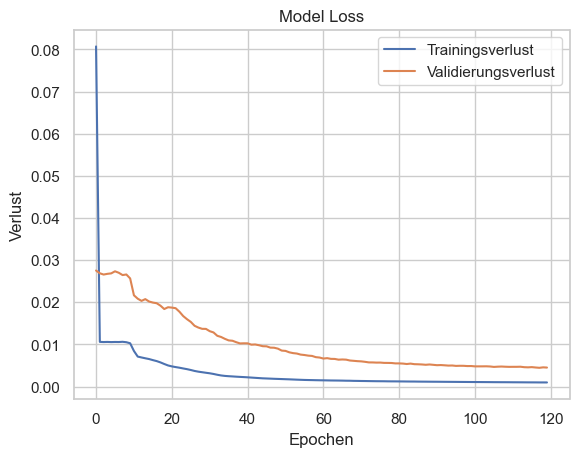

In [239]:
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Model Loss')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()
plt.show()

Dieser Code führt Vorhersagen auf dem Testdatensatz aus und berechnet den mittleren quadratischen Fehler (MSE = Mean Squared Error) zwischen den Originaldaten und den Vorhersagen. 

Dann wird eine Schwellenwert basierend auf den durchschnittlichen Rekonstruktionsfehlern für die normalen und anomalen Daten bestimmt. Die Signale, welche einen höheres MSE als der Schwellenwert haben, werden als Anomalie klassifiziert.

Schließlich wird die Klassifizierungsleistung des Modells unter Verwendung des Klassifikationsreports von Scikit-learn evaluiert.

In [240]:
# Vorhersagen auf dem Testdatensatz durch
test_predictions = model.predict(test_data)

# Berechnen des mittleren quadratischen Fehler (MSE) zwischen den Originaldaten und den Vorhersagen
mse = np.mean(np.power(test_data - test_predictions, 2), axis=2)

# Berechnen des durchschnittliche Rekonstruktionsfehlers für die normalen und anomalen Daten
normal_mse = np.mean(mse[:len(normal_data)], axis=1)
anomalous_mse = np.mean(mse[len(normal_data):], axis=1)

# Bestimmen eines Schwellenwerts, ab dem ein Signal als anomal eingestuft werden kann
threshold = 0.5 * (normal_mse.mean() + anomalous_mse.mean())

# Labeln als normal oder anomal basierend auf dem Schwellenwert
test_labels = np.where(mse >= threshold, 1, 0)

# Auswerten der Klassifizierungsleistung
from sklearn.metrics import classification_report
print(classification_report(np.concatenate((np.zeros(len(normal_data)), np.ones(len(anomalous_data)))), test_labels, target_names=['normal', 'anomalous']))


157/157 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

      normal       0.88      0.98      0.93      2919
   anomalous       0.97      0.81      0.88      2079

    accuracy                           0.91      4998
   macro avg       0.92      0.89      0.90      4998
weighted avg       0.92      0.91      0.91      4998



Unsere Präzisionsrate hier von 0,88 für "normal" bedeutet, dass das Modell in 88% der Fälle korrekt vorhersagte, dass die Daten normal waren. Unser Recall gibt hier an, dass tatsächlich positive Fälle (in diesem Fall Anomalien) zu erkennen waren. Der F1-Score ist der der gewichtete Durchschnitt von Precision und Recall, der die Ausgewogenheit zwischen beiden misst. Eine F1-Score von 0,93 für "normal" und 0,88 für "anomal" zeigt, dass das Modell insgesamt eine gute Leistung erbracht hat, aber bei der Erkennung von Anomalien etwas schlechter war.

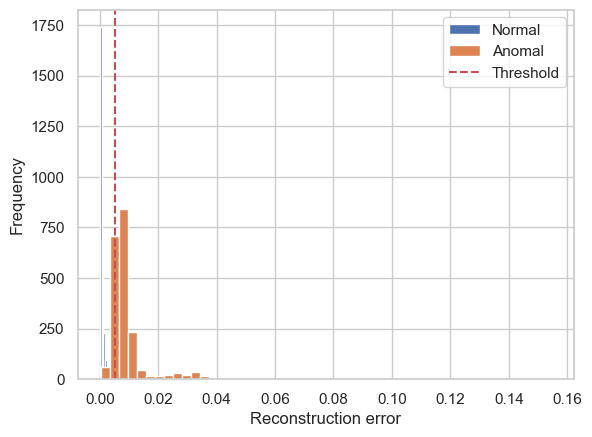

In [243]:
# Plotten der Verteilung der Rekonstruktionsfehler für normale und anomale Daten

plt.hist(normal_mse, bins=50, label='Normal')
plt.hist(anomalous_mse, bins=50, label='Anomal')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [250]:
print("Der Schwellenwert für den normalen und anomalen LSTM-Autoencoder liegt bei {:.4f}".format(threshold))

Der Schwellenwert für den normalen und anomalen LSTM-Autoencoder liegt bei 0.0052


Dies bedeutet, dass alle Rekonstruktionsfehler, die größer als dieser Schwellenwert sind, somit als anomale Daten eingestuft werden können. 

### **Literaturverzeichnis**

[1] https://www.kaggle.com/code/lionsai/p2-autoencoder-for-anomaly-detection-in-ecg/input  [28.03.2023] 

[2] https://scikit-learn.org/stable/ [28.03.23]  

[3] – Understanding LSTM – a tutorial into Long Short-Term Memory Recurrent Neural Networks 

Ralf C. Staudemeyer Faculty of Computer Science Schmalkalden University ofApplied Sciences, Germany 

[4] https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352 [30.03.2023] 

[5] https://en.wikipedia.org/wiki/Artificial_neural_network [30.03.2023]  

[6] Udemy Kurs - Der große Deep Learning Kurs mit Keras und TensorFlow 2 [30.03.2023]  

[7] https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network [30.03.2023] 

[8] https://de.wikipedia.org/wiki/Autoencoder [30.03.2023]

[9] https://www.datacamp.com/tutorial/autoencoder-keras-tutorial [30.03.2023]